 # Step 1:

 - Importing necessary libraries for deep learning, data handling, preprocessing, model training, evaluation, visualization, and experiment tracking.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import wandb
from types import SimpleNamespace
import random
import getpass

# Step 2:

Set device to GPU if available, else use CPU

Define a helper function to calculate output image size after a convolution

 Define a customizable convolutional neural network builder function

 `get_convnet`:

 - Allows setting number of filters, filter sizes, activation functions, pooling, padding, etc.
 - Supports batch normalization and dropout
 - Automatically computes final fully connected input size based on conv layers
 - Returns the model as an nn.Sequential module
 Example usage: builds and prints a sample CNN model with default parameters


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def img_size(img_w, filter_size, padding, stride):
    return ((img_w - filter_size + 2 * padding) // stride) + 1

In [ ]:
def get_convnet(in_channels=3, num_filters=[32, 64, 128, 256, 512],
                filter_size=[3, 3, 5, 5, 7], activation='relu',
                stride=1, padding='same', pool_size=(2, 2),
                fc_size=512, num_classes=10, dropout=0.5,
                batch_norm=True, device='cpu', input_size=(224, 224)):

    activations = {
        'relu': nn.ReLU(),
        'gelu': nn.GELU(),
        'silu': nn.SiLU(),
        'mish': nn.Mish()
    }

    if activation not in activations:
        raise ValueError(f"Invalid activation function '{activation}'. Choose from {list(activations.keys())}.")

    activation_fn = activations[activation]

    model_layers = []
    channels = in_channels
    height, width = input_size

    for i in range(len(num_filters)):
        if padding == 'same':
            pad = (filter_size[i] - 1) // 2
        else:
            pad = padding

        model_layers.append(nn.Conv2d(channels, num_filters[i], filter_size[i], stride=stride, padding=pad))
        if batch_norm:
            model_layers.append(nn.BatchNorm2d(num_filters[i]))
        model_layers.append(activation_fn)
        model_layers.append(nn.MaxPool2d(pool_size, stride=2))
        height = (height + 2 * pad - filter_size[i]) // stride + 1
        height = (height - pool_size[0]) // pool_size[0] + 1
        width = (width + 2 * pad - filter_size[i]) // stride + 1
        width = (width - pool_size[1]) // pool_size[1] + 1
        channels = num_filters[i]

    model_layers.append(nn.Flatten())
    fc_input_size = channels * height * width
    model_layers.append(nn.Linear(fc_input_size, fc_size))

    if batch_norm:
        model_layers.append(nn.BatchNorm1d(fc_size))

    model_layers.append(activation_fn)
    model_layers.append(nn.Dropout(dropout))
    model_layers.append(nn.Linear(fc_size, num_classes))

    model = nn.Sequential(*model_layers).to(device)

    return model
model=get_convnet()
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kern

# Step 3:

- Define model_training() function:
- Moves model to selected device (GPU/CPU)
- Initializes loss function (CrossEntropy) and optimizer (Adam)
- Sets up Weights & Biases (wandb) for logging if enabled
- Trains model over specified number of epochs:
  - Computes training loss and accuracy
  - Evaluates model on validation data each epoch
  - Logs metrics to wandb and prints progress
- After training, displays a plot of training vs. validation accuracy



In [ ]:
def model_training(model, train_data, val_data, epochs=10, device='cuda', lr=0.001, use_wandb=True):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    if use_wandb:
        wandb.init(project="DL_CNN", config={"epochs": epochs, "lr": lr})
        wandb.watch(model, log="all")

    train_acc_list = []
    val_acc_list = []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_data:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_data)
        train_accuracy = 100 * correct / total
        train_acc_list.append(train_accuracy)

        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in val_data:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = 100 * correct_val / total_val
        val_acc_list.append(val_accuracy)

        if use_wandb:
            wandb.log({
                'epoch': epoch + 1,
                'Train loss': avg_loss,
                'Train accuracy': train_accuracy,
                'val_accuracy': val_accuracy
            })

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")

    if use_wandb:
        wandb.finish()

    print("Training complete!")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_acc_list, label="Training Accuracy", marker='o',color="blue")
    plt.plot(range(1, epochs + 1), val_acc_list, label="Validation Accuracy", marker='o',color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training & Validation Accuracy over Epochs")
    plt.legend()
    plt.grid()
    plt.show()
    return

# Step 4
- Visualizes 10 random images from a randomly selected class in the training dataset
- Loads class folders from the training directory
- Picks one random class and samples 10 images from it
- Displays the selected images using matplotlib without axis labels
- Titles each image with the class name for reference


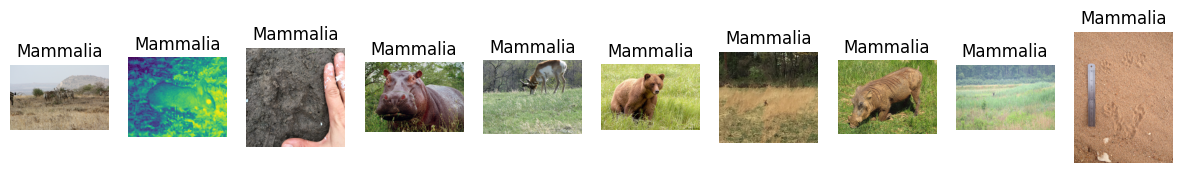

In [ ]:
train_data_dir = '/kaggle/input/12kimage/inaturalist_12K/train'
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
class_folders = os.listdir(train_data_dir)
random_class = random.choice(class_folders)
class_path = os.path.join(train_data_dir, random_class)
image_files = random.sample(os.listdir(class_path), 10)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for ax, img_file in zip(axes, image_files):
    img_path = os.path.join(class_path, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(random_class)
plt.show()

# Step 5:
- Loads image dataset from the given directory and applies transformations
- Applies data augmentation if 'Yes' is passed as the data_augmentation flag
- Uses torchvision transforms for resizing, normalization, and optional augmentation (crop, flip, color jitter, rotation)
- Splits the dataset into training and validation sets (80-20 split)
- Returns DataLoaders for training and validation, the full dataset, and index lists for train/val samples


In [ ]:
def data_load(train_data_dir, data_augmentation):
    base_transforms = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]

    augmentation_transforms = [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(20)
    ]

    transform_img = transforms.Compose(augmentation_transforms + base_transforms) if data_augmentation == 'Yes' else transforms.Compose(base_transforms)

    dataset = ImageFolder(root=train_data_dir, transform=transform_img)
    train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
    train_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(train_indices))
    val_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(val_indices))
    return train_loader, val_loader,dataset,train_indices,val_indices


# Step 6:
- Calls the data_load function with data augmentation enabled to load training and validation data
- Prints total number of images in the full dataset
- Prints the number of images used for training and validation
- Prints the number of batches in training and validation DataLoaders


In [ ]:
train_loader,val_loader,dataset,train_indices, val_indices=data_load(train_data_dir, data_augmentation="Yes")
print(f"Total images in dataset: {len(dataset)}")
print(f"Total images in training dataset: {len(train_indices)}")
print(f"Total images in validation dataset: {len(val_indices)}")
print(f"Number of batches in training data: {len(train_loader)}")
print(f"No of batches in validation data: {len(val_loader)}")

Total images in dataset: 9999
Total images in training dataset: 7999
Total images in validation dataset: 2000
Number of batches in training data: 250
No of batches in validation data: 63


- Retrieves the number of batches in training and validation DataLoaders
- Extracts one batch of images and labels from each loader using iter()
- Prints the total number of batches in training and validation sets
- Prints the shape of the image tensors in the first training and validation batches


In [ ]:
train_samples = len(train_loader)
val_samples = len(val_loader)
train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))
print(f"Total training samples: {train_samples}")
print(f"training Image shape: {train_images.shape}")
print(f"Total val samples: {val_samples}")
print(f"val Image shape: {val_images.shape}")


Total training samples: 250
training Image shape: torch.Size([32, 3, 224, 224])
Total val samples: 63
val Image shape: torch.Size([32, 3, 224, 224])


# Step 7:
Wandb Sweep

In [ ]:
!pip install wandb

Loging In Wandb

In [ ]:
api_key = getpass.getpass("Enter your W&B API Key: ")
wandb.login(key=api_key)

Enter your W&B API Key:  ········


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ma24m022 (ma24m022-indian-institute-of-technology-madras). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

- Defines a hyperparameter sweep configuration using Bayesian optimization with Weights & Biases (wandb)
- Objective is to maximize validation accuracy ('val_accuracy')
- Specifies the parameter search space:
  - kernel_size: different lists of convolution filter sizes
  - dropout: various dropout probabilities to regularize the model
  - activation: activation functions to try (ReLU, SiLU, Mish, GELU)
  - num_dense: size of the fully connected layer
  - batch_norm: toggle for using batch normalization
  - filter_org: different configurations for the number of filters per convolutional layer
- Initializes the sweep and gets the sweep ID


In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'kernel_size': {'values': [[3,5,7,9,9], [3,5,5,5,5],[3,3,3,3,3], [3,3,5,7,9], [5,7,7,9,9]]},
        'dropout': {'values': [0.1,0.2,0.3, 0.4,0.5,0.05, 0.01, 0.02]},
        'activation': {'values': ['relu', 'silu', 'mish', 'gelu']},
        'num_dense': {'values': [128, 256, 512]},
        'batch_norm': {'values': [True, False]},
        'filter_org': {'values': [[128,128,64,64,32], [32,64,128,256,512], [32,32,32,32,32], [32,64,64,128,128]]},
        # 'learning_rate': {'values': [0.1, 0.05, 0.01, 0.005,0.0001]}
    }
}
sweep_id = wandb.sweep(sweep=sweep_config, project="DL_CNN")

Create sweep with ID: 4x5zntl4
Sweep URL: https://wandb.ai/ma24m022-indian-institute-of-technology-madras/DL_CNN/sweeps/4x5zntl4


- Main function to train the model using W&B sweep configuration
- Initializes the model based on sweep parameters, including kernel size, activation function, dropout rate, and more
- Constructs a run name using the current configuration to track experiments in W&B
- Initializes the selected activation function based on sweep config
- Calls `get_convnet()` to build the convolutional model with specified parameters
- Checks that the `train_loader` is defined before training
- Uses the W&B-specified learning rate and calls `model_training()` to train the model
- Finalizes the W&B run with `wandb.finish()`


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eqnbj7bu with config:
wandb: 	activation: gelu
wandb: 	batch_norm: True
wandb: 	dropout: 0.02
wandb: 	filter_org: [128, 128, 64, 64, 32]
wandb: 	kernel_size: [5, 7, 7, 9, 9]
wandb: 	num_dense: 256


wandb: WARNING Ignoring project 'DL_CNN' when running a sweep.


Epoch 1/10 | Train Loss: 2.2331 | Train Acc: 17.29% | Val Acc: 20.45%
Epoch 2/10 | Train Loss: 2.1744 | Train Acc: 20.64% | Val Acc: 20.95%
Epoch 3/10 | Train Loss: 2.1628 | Train Acc: 20.57% | Val Acc: 22.30%
Epoch 4/10 | Train Loss: 2.1258 | Train Acc: 23.20% | Val Acc: 21.75%
Epoch 5/10 | Train Loss: 2.1276 | Train Acc: 22.99% | Val Acc: 24.25%
Epoch 6/10 | Train Loss: 2.0966 | Train Acc: 24.39% | Val Acc: 24.95%
Epoch 7/10 | Train Loss: 2.0913 | Train Acc: 24.45% | Val Acc: 20.95%
Epoch 8/10 | Train Loss: 2.0706 | Train Acc: 25.09% | Val Acc: 27.45%
Epoch 9/10 | Train Loss: 2.0521 | Train Acc: 25.63% | Val Acc: 26.40%
Epoch 10/10 | Train Loss: 2.0364 | Train Acc: 27.15% | Val Acc: 22.90%


Training complete!


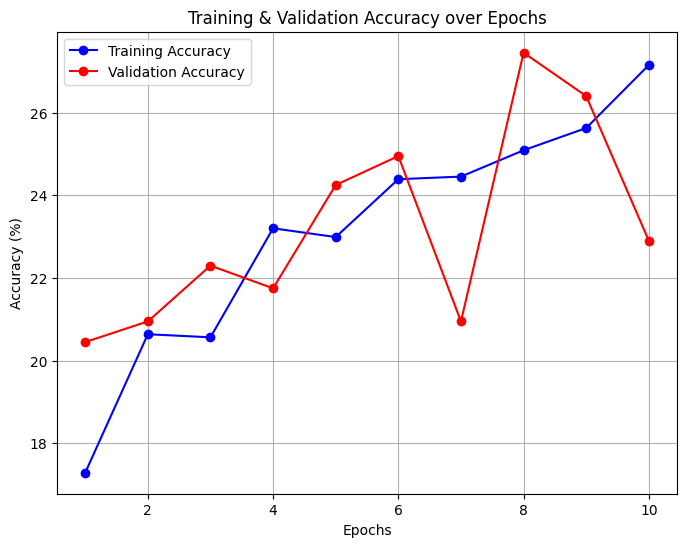

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with wandb.init() as run:
        config = wandb.config

        run_name = (f"KK_E_s-{config.kernel_size}__ac-{config.activation}"
                    f"_drop-{config.dropout}"
                    f"_fs-{config.filter_org}_bn-{config.batch_norm}"
                    f"_dense-{config.num_dense}")
        wandb.run.name = run_name

        activations = {
            "relu": nn.ReLU(),
            "gelu": nn.GELU(),
            "silu": nn.SiLU(),
            "mish": nn.Mish(),
        }
        activ = activations.get(config.activation, nn.ReLU())

        model = get_convnet(
            in_channels=3,
            num_filters=config.filter_org,
            filter_size=config.kernel_size,
            activation=config.activation,
            stride=1,
            padding=1,
            pool_size=(2, 2),
            fc_size=config.num_dense,
            num_classes=10,
            dropout=config.dropout,
            batch_norm=config.batch_norm,
            device=device
        ).to(device)

        if "train_loader" not in globals():
            raise ValueError("train_loader is not defined. Load the dataset before calling model_train_test().")
        model_training(model, train_loader, val_loader,10,
                       device='cuda',
                       lr=0.001,
                       use_wandb=True)

wandb.agent(sweep_id, function=main, count=1)
wandb.finish()


# Step 8:
- Loads validation images from the specified directory (`test_data_dir`)
- Randomly selects a class from the validation data folders
- Samples 10 images from the randomly selected class
- Displays the 10 selected images in a 1x10 grid without axis labels
- Titles each image with the class name

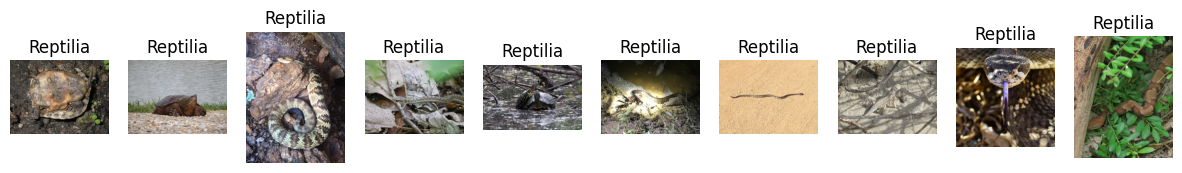

In [ ]:
test_data_dir = '/kaggle/input/12kimage/inaturalist_12K/val'
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
class_folders = os.listdir(train_data_dir)
random_class = random.choice(class_folders)
class_path = os.path.join(train_data_dir, random_class)
image_files = random.sample(os.listdir(class_path), 10)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for ax, img_file in zip(axes, image_files):
    img_path = os.path.join(class_path, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(random_class)
plt.show()

# step 9:
- Defines the function `test_data_load` to load and preprocess the test dataset
- Applies a series of transformations (resizing, normalization, and optional data augmentation)
- Augmentation includes random resized crop, horizontal flip, color jitter, and random rotation
- Returns a DataLoader for the test dataset to batch the images for evaluation
- Calls the function with `data_augmentation` set to "No"
- Prints the total number of images in the test dataset and the number of batches in the test DataLoader


In [ ]:
def test_data_load(test_data_dir, data_augmentation):
    base_transforms = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
    augmentation_transforms = [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(20)
    ]
    transform_img = transforms.Compose(augmentation_transforms + base_transforms) if data_augmentation == 'Yes' else transforms.Compose(base_transforms)
    test_indices = ImageFolder(root=test_data_dir, transform=transform_img)
    test_loader = DataLoader(test_indices, batch_size=32)
    return test_loader,test_indices

In [ ]:
test_loader,test_indices=test_data_load(test_data_dir, data_augmentation="No")
print(f"Total images in test dataset: {len(test_indices)}")
print(f"Total images  in test dataset: {len(test_loader)}")

Total images in test dataset: 2000
Total images  in test dataset: 63


# Step 10:
- Defines a function `test` to evaluate the model's performance on the test dataset
- Switches the model to evaluation mode using `model.eval()`
- Initializes counters for correct predictions and total samples
- Loops over the test data and performs predictions without calculating gradients (`torch.no_grad()`)
- Calculates the number of correct predictions and the total number of samples
- Computes the test accuracy as the percentage of correct predictions
- Prints and returns the test accuracy


In [ ]:
def test(model, test_data, device="cpu"):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_data:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = 100 * correct / total

    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy

# Step 11:
- Defines the `model_training` function to train and validate the model for a specified number of epochs
- Moves the model to the specified device (GPU or CPU)
- Initializes the loss function (CrossEntropyLoss) and optimizer (Adam) for training
- Tracks training accuracy and validation accuracy for each epoch
- In each epoch:
  - Switches to training mode with `model.train()`
  - Computes the loss and performs backpropagation to update the model's parameters
  - Tracks the training loss and accuracy for the current epoch
  - Switches to evaluation mode with `model.eval()` for validation
  - Computes validation accuracy without gradient calculations using `torch.no_grad()`
  - Prints the training loss, training accuracy, and validation accuracy for each epoch
- Returns the trained model after all epochs are completed


In [ ]:
def model_training(model, train_data, val_data, epochs=10, device='cuda', lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_acc_list = []
    val_acc_list = []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_data:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_data)
        train_accuracy = 100 * correct / total
        train_acc_list.append(train_accuracy)

        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in val_data:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = 100 * correct_val / total_val
        val_acc_list.append(val_accuracy)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")
    print("Training complete!")
    return model

# Step 12:
- Sets the device to 'cuda' if a GPU is available, otherwise defaults to 'cpu'
- Initializes a convolutional neural network model with the following configuration:
  - `in_channels=3` (for RGB images)
  - `num_filters=[128, 128, 64, 64, 32]` (number of filters for each convolutional layer)
  - `filter_size=[3, 3, 3, 3, 3]` (filter size for each convolutional layer)
  - `activation='mish'` (activation function used for non-linearity)
  - `stride=1` (stride for the convolutions)
  - `padding='same'` (padding for the convolution layers to maintain input size)
  - `pool_size=(2, 2)` (pooling layer size)
  - `fc_size=256` (fully connected layer size)
  - `num_classes=10` (number of classes for classification)
  - `dropout=0.3` (dropout rate to prevent overfitting)
  - `batch_norm=True` (use batch normalization to improve training)
  - `device=device` (use GPU or CPU as defined earlier)
- Trains the model using the `model_training` function with 30 epochs and a learning rate of 0.001
- Evaluates the trained model on the test set using the `test` function, which computes and prints the test accuracy


In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model = get_convnet(
    in_channels=3,
    num_filters=[128,128,64,64,32],
    filter_size=[3, 3, 3, 3, 3],
    activation='mish',
    stride=1,
    padding='same',
    pool_size=(2, 2),
    fc_size=256,
    num_classes=10,
    dropout=0.3,
    batch_norm=True,
    device=device
)
train_model=model_training(model, train_loader,val_loader, epochs=30, device='cuda', lr=0.001)
test(train_model,test_loader,'cuda')

Epoch 1/30 | Train Loss: 2.2195 | Train Acc: 18.45% | Val Acc: 24.05%
Epoch 2/30 | Train Loss: 2.1403 | Train Acc: 22.40% | Val Acc: 22.05%
Epoch 3/30 | Train Loss: 2.1067 | Train Acc: 24.20% | Val Acc: 24.00%
Epoch 4/30 | Train Loss: 2.0741 | Train Acc: 25.43% | Val Acc: 24.80%
Epoch 5/30 | Train Loss: 2.0503 | Train Acc: 26.24% | Val Acc: 27.85%
Epoch 6/30 | Train Loss: 2.0235 | Train Acc: 27.90% | Val Acc: 27.20%
Epoch 7/30 | Train Loss: 2.0172 | Train Acc: 27.99% | Val Acc: 26.90%
Epoch 8/30 | Train Loss: 1.9884 | Train Acc: 28.92% | Val Acc: 23.15%
Epoch 9/30 | Train Loss: 1.9772 | Train Acc: 28.68% | Val Acc: 29.70%
Epoch 10/30 | Train Loss: 1.9573 | Train Acc: 30.35% | Val Acc: 32.10%
Epoch 11/30 | Train Loss: 1.9383 | Train Acc: 31.00% | Val Acc: 32.30%
Epoch 12/30 | Train Loss: 1.9047 | Train Acc: 32.23% | Val Acc: 31.45%
Epoch 13/30 | Train Loss: 1.8994 | Train Acc: 32.72% | Val Acc: 30.05%
Epoch 14/30 | Train Loss: 1.8890 | Train Acc: 32.37% | Val Acc: 33.50%
Epoch 15/30 | T

43.15

# Step 13:
- Defines the `plot_predictions_grid` function to visualize the model's predictions on a subset of the dataset
- Takes the following parameters:
  - `model`: The trained model to make predictions
  - `dataset`: The dataset containing images and their labels
  - `device`: The device (CPU or GPU) where the model is loaded
  - `num_images`: Number of images to display (default is 30)
- The function:
  - Sets the model to evaluation mode using `model.eval()`
  - Randomly selects `num_images` indices from the dataset
  - Creates a grid of subplots to display the images and their predicted vs. true labels
  - For each image:
    - Loads the image and its true label
    - Runs the image through the model to get the predicted label
    - Converts the image from tensor format to NumPy array for plotting
    - Displays the image along with its predicted and true labels in the grid
  - Tightens the layout and shows the grid of images with predictions


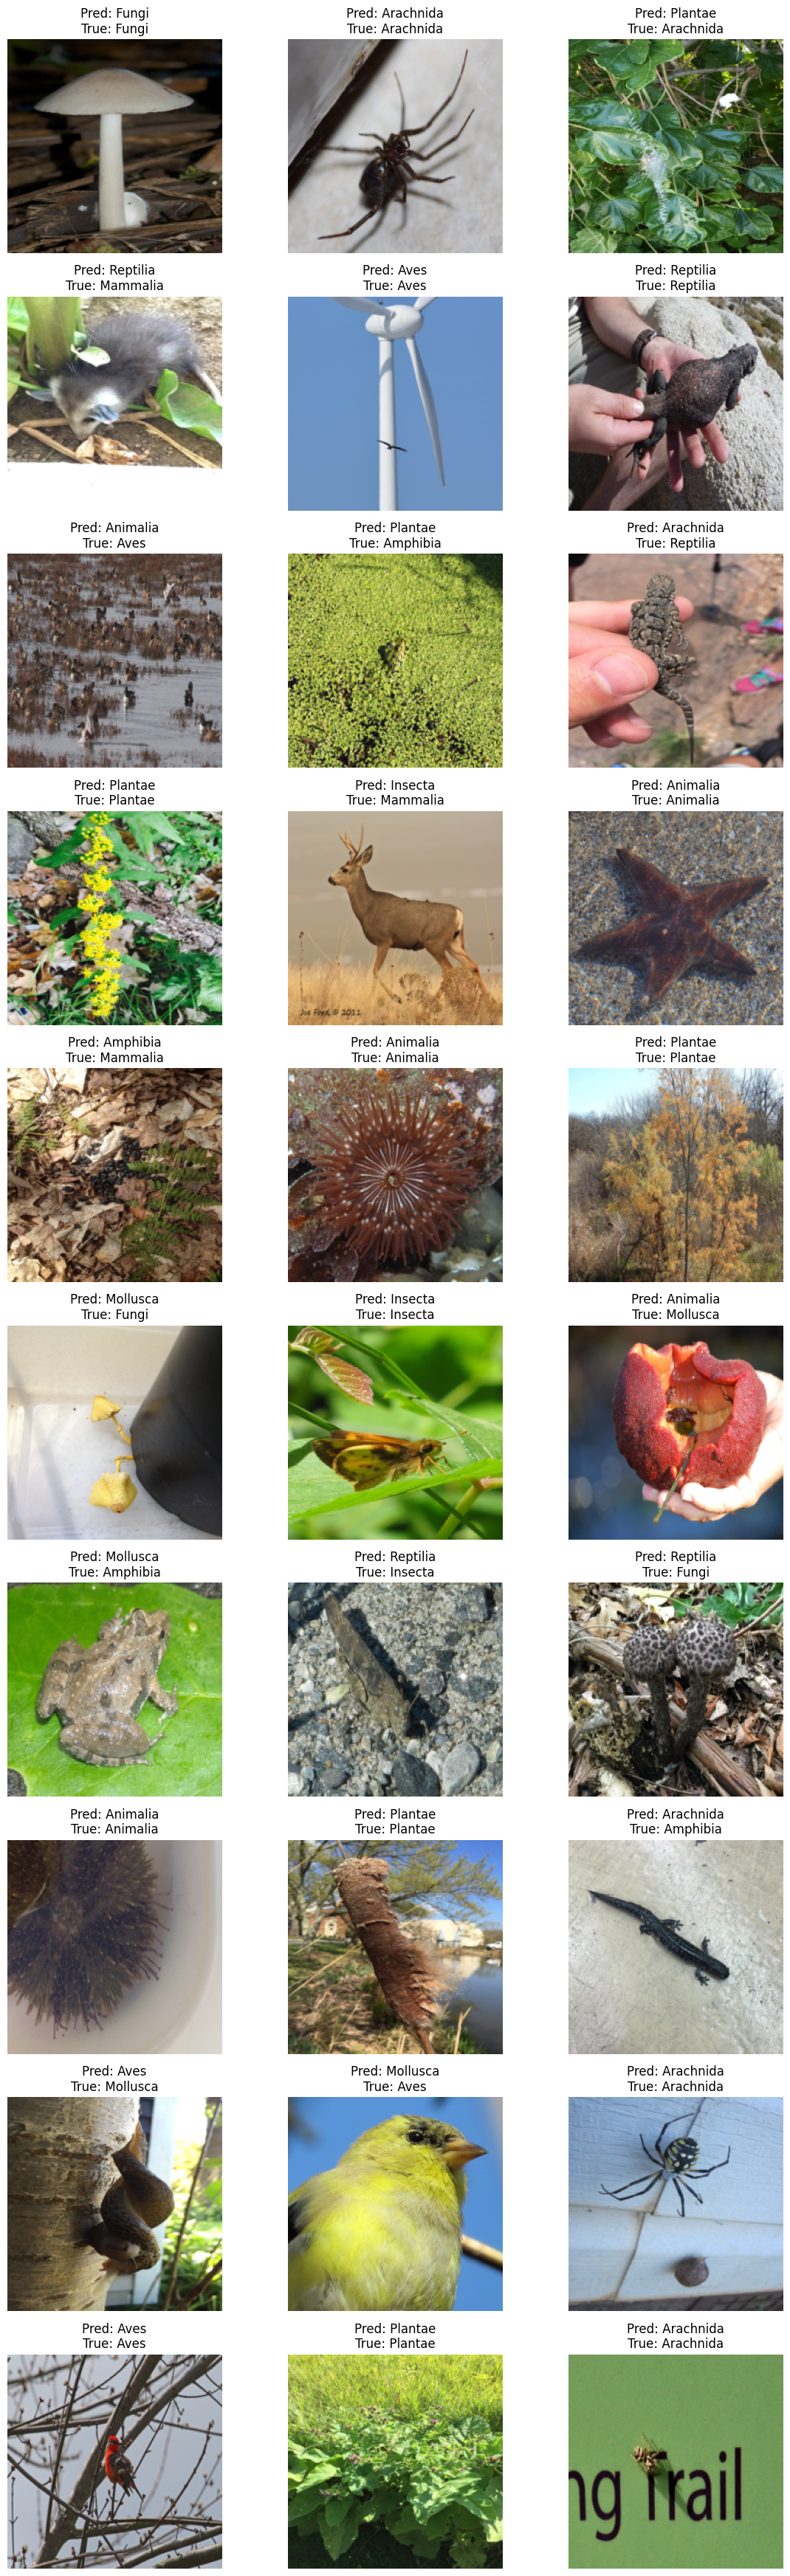

In [ ]:
def plot_predictions_grid(model, dataset, device, num_images=30):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(10, 3, figsize=(12, 35))

    for ax, idx in zip(axes.flatten(), indices):
        img, true_label = dataset[idx]
        input_img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_img)
            _, pred_label = torch.max(output, 1)

        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np * 0.5) + 0.5

        ax.imshow(img_np)
        ax.axis("off")
        ax.set_title(f"Pred: {dataset.classes[pred_label.item()]}\nTrue: {dataset.classes[true_label]}")

    plt.tight_layout()
    plt.show()

plot_predictions_grid(train_model, test_indices, device)

# Step 14:
- Defines the `plot_first_layer_filters` function to visualize the first layer filters of a Convolutional Neural Network (CNN)
- Takes the following parameter:
  - `model`: The trained model from which to extract and display the first layer filters
- The function:
  - Extracts the first convolutional layer from the model using `list(model.children())[0]`
  - Checks if the first layer has a `weight` attribute (indicating it’s a convolutional layer) and retrieves the filter weights
  - Creates a grid of 8x8 subplots to display the filters
  - Loops over the filters and displays each in grayscale on the subplots
  - Adds a title to the figure: "8x8 Grid of First-Layer Filters"
  - Tightens the layout and shows the grid of filters


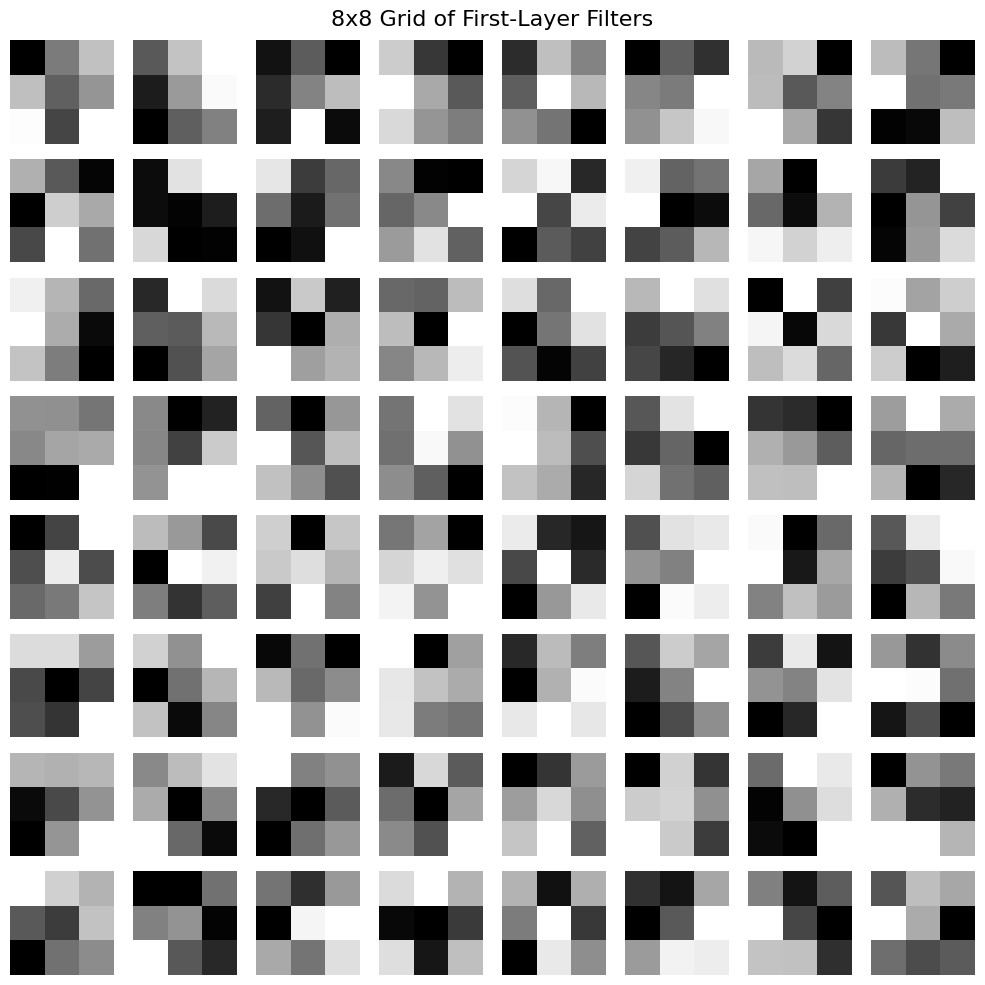

In [ ]:
def plot_first_layer_filters(model):
    first_layer = list(model.children())[0]
    if hasattr(first_layer, 'weight'):
        filters = first_layer.weight.data.cpu()
    else:
        filters = list(first_layer.children())[0].weight.data.cpu()

    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i >= filters.shape[0]:
            break
        ax.imshow(filters[i][0], cmap='gray')
        ax.axis('off')
    fig.suptitle("8x8 Grid of First-Layer Filters", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_first_layer_filters(train_model)